In [89]:
# ignore most of these imports this notebook used to do sth else
import numpy as np

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset

import pandas as pd

from matplotlib import pyplot

import mne
from mne.io import concatenate_raws, read_raw_fif
import mne.viz

from os import walk

In [79]:
# link to dataset: https://zenodo.org/record/197404#.X1Li7HlKiUl
# there are 27 participants in the trial, and each file name contains the ID of its participant
participant_prefix = ['P-{:02}_'.format(x) for x in range(1, 28)]
print(participant_prefix)

['P-01_', 'P-02_', 'P-03_', 'P-04_', 'P-05_', 'P-06_', 'P-07_', 'P-08_', 'P-09_', 'P-10_', 'P-11_', 'P-12_', 'P-13_', 'P-14_', 'P-15_', 'P-16_', 'P-17_', 'P-18_', 'P-19_', 'P-20_', 'P-21_', 'P-22_', 'P-23_', 'P-24_', 'P-25_', 'P-26_', 'P-27_']


In [80]:
files = []
# study1_eeg is a folder with a bunch of csv files, each file partaining to a different trial
path = 'study1_eeg/'
for prefix in participant_prefix:
    for (dirpath, dirnames, filenames) in walk(path):
        # gets the file paths and adds them to a list
        new_names = [dirpath+f for f in filenames if (prefix in f)]
        files.extend(new_names)
        break

In [92]:
tmp = np.loadtxt(files[0], delimiter=',')
# finds the number of channels from the shape of the file (channels X timepoints)
print(tmp.shape)

(64, 384)


In [81]:
n_channels = tmp.shape[0]
n_times = tmp.shape[1]

# makes an array large enough to hold all of the data
participant_data = np.ndarray((len(files),n_channels,n_times))

for trial in range(0,len(files)):
    # each iteration loads data from a trial
    new_data = np.loadtxt(files[trial], delimiter=',')
    if trial == 0:
        # just reassuring again that is the right shape
        print('n_channels, n_times: ' + str(new_data.shape))
    new_data = new_data.astype(float)
    participant_data[trial] = new_data

print('Number of epochs: ' + str(participant_data.shape))

n_channels, n_times: (64, 384)
Number of epochs: (16666, 64, 384)


In [82]:
# gets the ID of the events from the names of each file
epochs_events = []
for f in files:
    res = f.split('_')
    epochs_events.append(res[-2])

In [99]:
unique_events = list(set(epochs_events))
print(unique_events)
unique_events = sorted(unique_events)
print(unique_events)
unique_events_num = [i for i in range(len(unique_events))]

# formats a numpy array to work with the epochs object 
# format = (event #, prev event class, current event class)
epoch_events_num = np.ndarray((len(epochs_events),3),int)

for i in range(len(epochs_events)):
    for j in range(len(unique_events)):
        if epochs_events[i] == unique_events[j]:
            epoch_events_num[i,2] = unique_events_num[j]
            if i > 0:
                epoch_events_num[i,1] = epoch_events_num[i-1,2]
            else:
                epoch_events_num[i,1] = unique_events_num[j]
        epoch_events_num[i,0] = i
        
# associates each event with an index
event_id = {}
for i in range(len(unique_events)):
    event_id[unique_events[i]] = unique_events_num[i]
print(event_id)

['FU', 'FP', 'FN', 'NU', 'NP', 'NN']
['FN', 'FP', 'FU', 'NN', 'NP', 'NU']
[16665     5     5]
{'FN': 0, 'FP': 1, 'FU': 2, 'NN': 3, 'NP': 4, 'NU': 5}


Number of channels: 64
Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


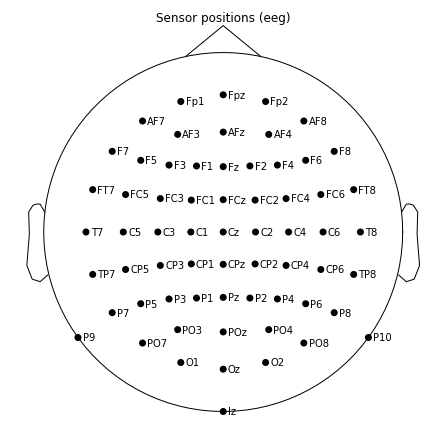

Number of channels after removing the fudicials: 64


In [85]:
%matplotlib inline

# data was taken with a biosemi eeg device, so biosemi64 is passed into the function
montage = mne.channels.make_standard_montage('biosemi64') 
print('Number of channels: ' + str(len(montage.ch_names)))
montage.plot(show_names=True)
n_channels = 64

# there are 64 channels in the cap but 67 in the montage, three are just there for
# reference (fiducial) and need to be removed
fiducials = ['Nz', 'LPA', 'RPA']
ch_names = montage.ch_names
ch_names = [x for x in ch_names if x not in fiducials]
print('Number of channels after removing the fudicials: '+ str(len(ch_names)))
# Specify ampling rate
sfreq = 256  # Hz

In [86]:
# creates an mne info instance with the different info we've collected
epochs_info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# creates an mne epochs object with the info and the data
epochs = mne.EpochsArray(data=participant_data, info=epochs_info, events=epoch_events_num, event_id=event_id)
epochs.set_montage(montage)

# drops bad epochs, doesn't actually do anything rn
epochs.drop_bad()

epochs.info

16666 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>

In [87]:
# save the epochs as a .fif
epochs.save('study1_eeg/epochdata/master.fif', verbose='error')

In [88]:
# example of loading the data
data_file = 'study1_eeg/epochdata/master'

# Read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif', verbose='error')
print(epochs)

<EpochsFIF  |   16666 events (all good), 0 - 1.49609 sec, baseline off, ~3.05 GB, data loaded,
 'FN': 4336
 'FP': 4371
 'FU': 4239
 'NN': 1238
 'NP': 1264
 'NU': 1218>
